In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
from cnnlib import utils, data_utils, functions
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from cnnlib.model_builder import ModelBuilder
import matplotlib.pyplot as plt
from torchinfo import summary

In [2]:
IMG_SIZE = 224
IMAGE_PATH = "/home/raguramk/workspace/Eva/EVA8P1/data/pizza_steak_sushi"
TRAIN_DIR = IMAGE_PATH + "/train"
TEST_DIR = IMAGE_PATH + "/test"

BATCH_SIZE = 32
DEVICE = utils.getDevice()

### Load the dataset

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)
Number of train images: 225
Number of test images: 75


['pizza', 'steak', 'sushi']

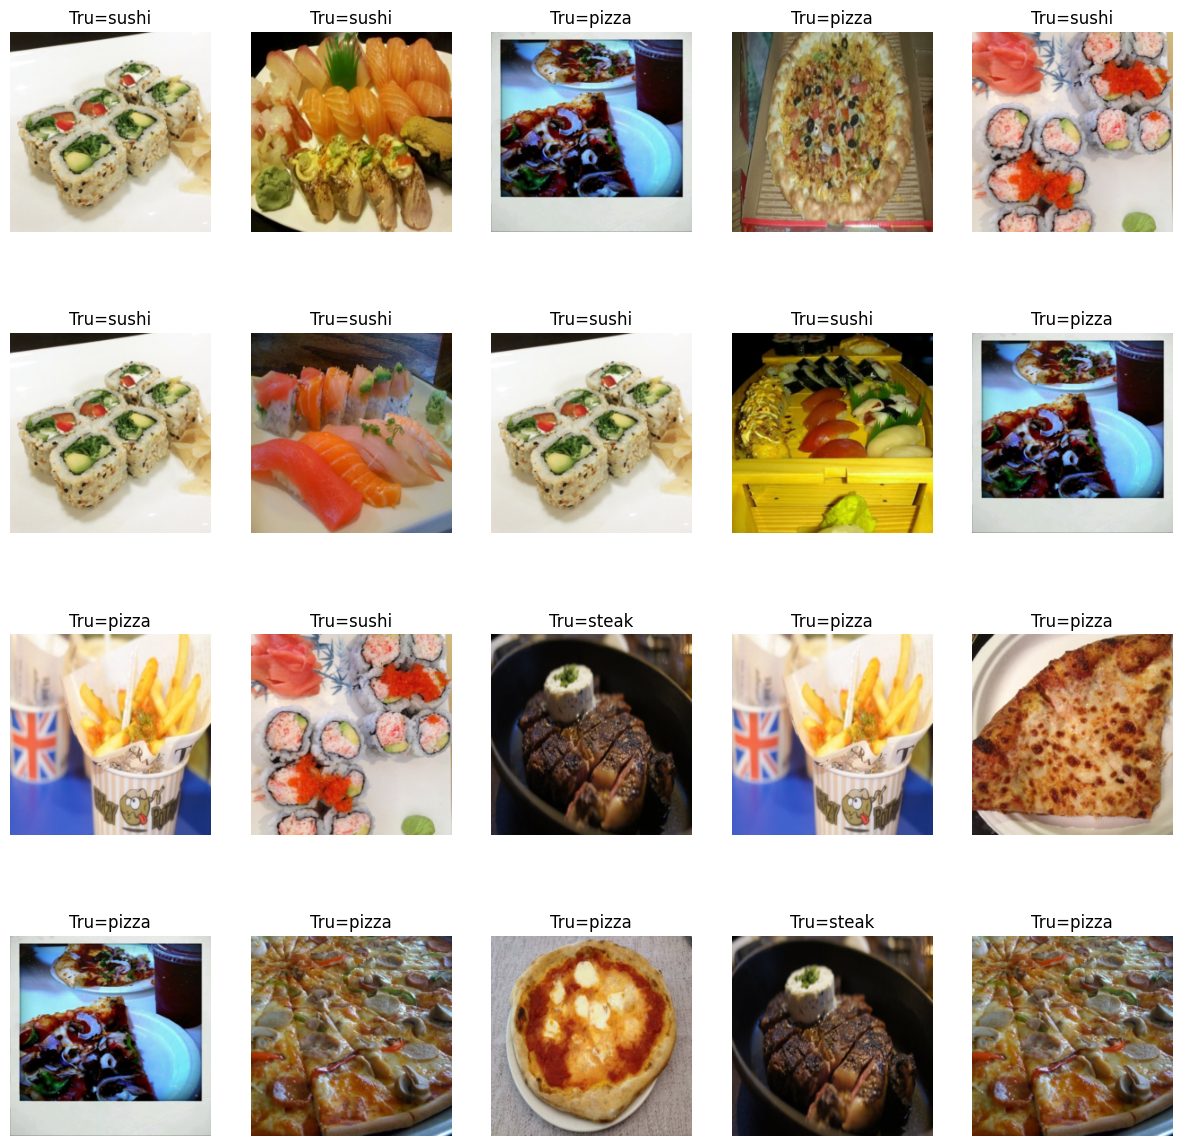

In [18]:
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Manually created transforms: {manual_transforms}")

data = data_utils.load_dataset(train_dir=TRAIN_DIR, test_dir=TEST_DIR, train_transforms=manual_transforms, test_transforms=manual_transforms, batch_size=BATCH_SIZE)
data_utils.showLoaderImages(data.train, classes=data.classes, count=20)

data.classes

### Understanding the patches

Each image is of size 224 x 224 x 3, where height is 224, width is 224 and channels is 3. Lets say I want to create patches of size 16. So, I will end up having 14 x 14 patches. Each patch will be 16 x 16 x 3 dimension
224 x 224 x 3 --> 14 x 14 patches each 16 x 16 x 3 dimension    


In [4]:
### Now let me take and example image and show how the patches are going to look like. 

height = 224
width = 224 
channels = 3 
patch_size = 16 

number_patches = (height * width) / patch_size ** 2

print(f"Number of patches: {number_patches}")
print(f"Embedding layer output shape: {(number_patches, patch_size * patch_size * channels)}")

Number of patches: 196.0
Embedding layer output shape: (196.0, 768)


In [5]:
# Get a batch of images
image_batch, label_batch = next(iter(data.train))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

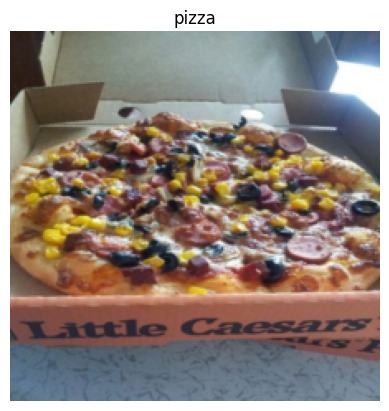

In [6]:
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(data.classes[label])
plt.axis(False)

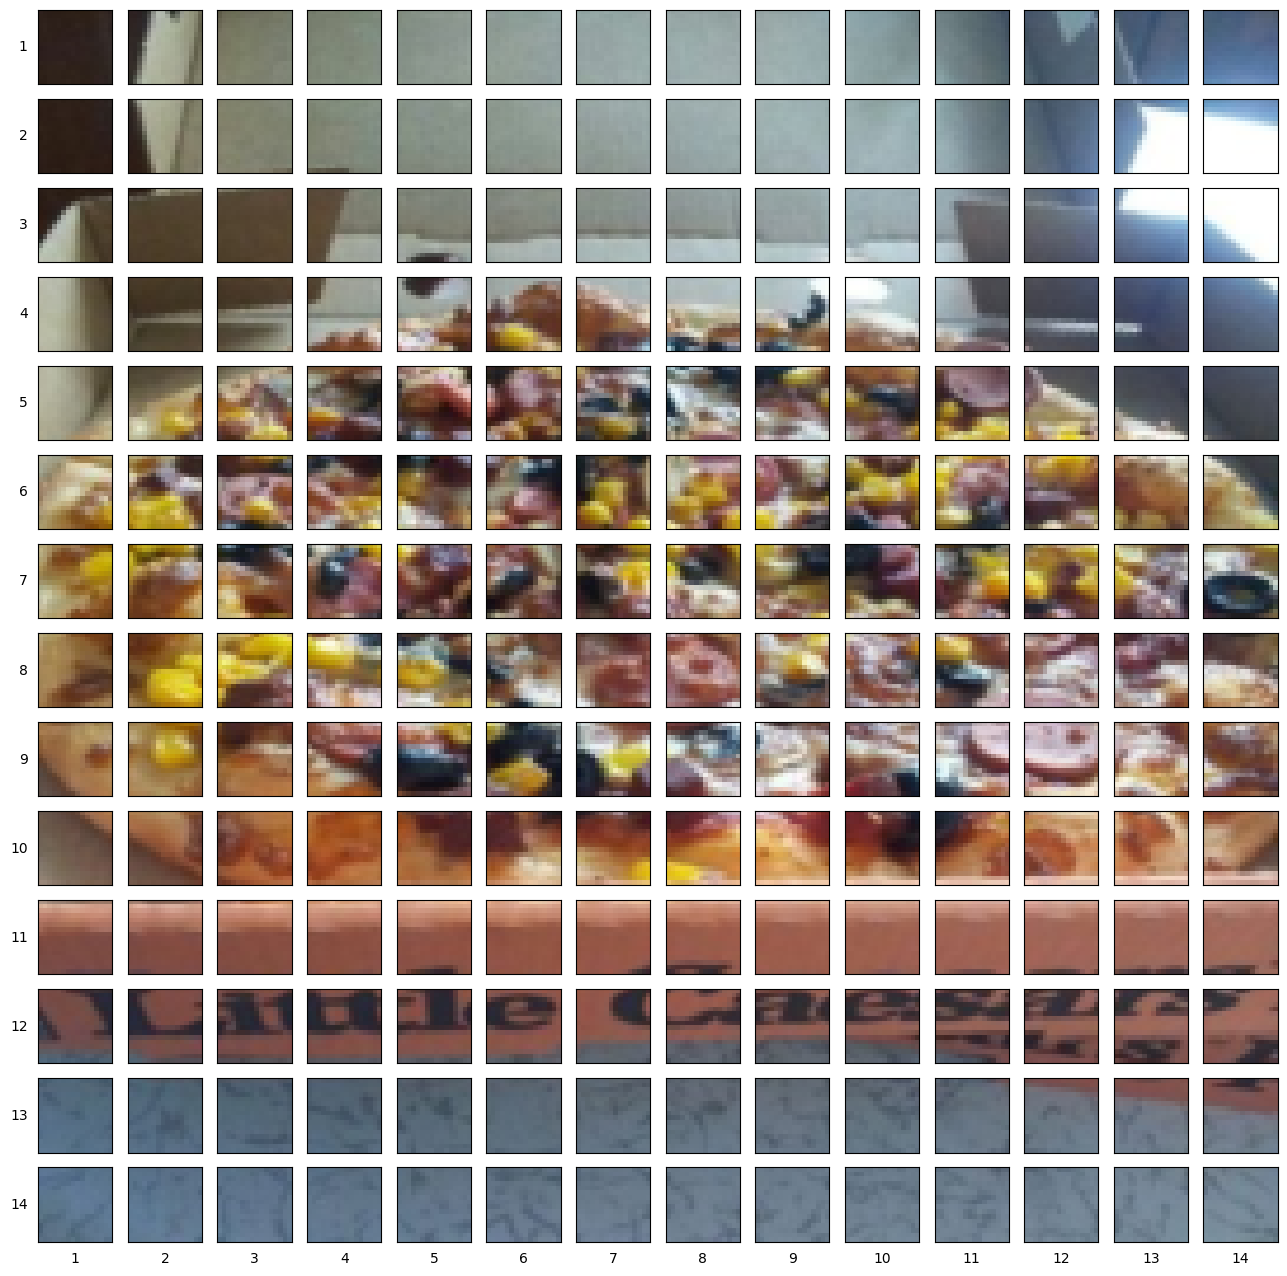

In [7]:
## Print the patches 

image_permuted = image.permute(1, 2, 0)

fig, axs = plt.subplots(nrows= 224 // 16, 
                        ncols = 224 // 16, 
                        figsize = (16, 16), 
                        sharex = True,
                        sharey = True)

for i, patch_height in enumerate(range(0, 224, 16)): 
    for j, patch_width in enumerate(range(0, 224, 16)): 
        
        axs[i,j].imshow(image_permuted[patch_height:patch_height+16, patch_width:patch_width+16, :])
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

plt.show() 

### Load the Model 

In [19]:
from cnnlib.models.vit import ViT

vit = ViT(out_classes=len(data.classes)).to(DEVICE)

summary(model=vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [20]:
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

criterion = nn.CrossEntropyLoss()

In [21]:
epochs = 30

builder = ModelBuilder(vit, data, criterion, optimizer)
result = builder.fit(epochs)



Epoch: 1


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.60it/s]


Train Accuracy: 36.44444444444444%, Train Loss: 0.16077958047389984, Learning Rate: 0.003


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Test Accuracy: 33.333333333333336%, Test Loss: 0.09318650513887405


Epoch: 2


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.62it/s]


Train Accuracy: 38.22222222222222%, Train Loss: 0.055822424590587616, Learning Rate: 0.003


Epoch: 3


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.57it/s]


Train Accuracy: 39.111111111111114%, Train Loss: 0.04637181758880615, Learning Rate: 0.003


Epoch: 4


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.68it/s]


Train Accuracy: 34.22222222222222%, Train Loss: 0.0475880391895771, Learning Rate: 0.003


Epoch: 5


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.60it/s]


Train Accuracy: 35.55555555555556%, Train Loss: 0.04435097426176071, Learning Rate: 0.003


Epoch: 6


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.67it/s]


Train Accuracy: 35.111111111111114%, Train Loss: 0.04360771179199219, Learning Rate: 0.003


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Test Accuracy: 25.333333333333332%, Test Loss: 0.05382003262639046


Epoch: 7


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.58it/s]


Train Accuracy: 36.888888888888886%, Train Loss: 0.04241233319044113, Learning Rate: 0.003


Epoch: 8


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.58it/s]


Train Accuracy: 32.44444444444444%, Train Loss: 0.0462590791285038, Learning Rate: 0.003


Epoch: 9


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.56it/s]


Train Accuracy: 33.333333333333336%, Train Loss: 0.041828274726867676, Learning Rate: 0.003


Epoch: 10


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.54it/s]


Train Accuracy: 34.666666666666664%, Train Loss: 0.04195202887058258, Learning Rate: 0.003


Epoch: 11


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.59it/s]


Train Accuracy: 33.77777777777778%, Train Loss: 0.04355158656835556, Learning Rate: 0.003


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Test Accuracy: 25.333333333333332%, Test Loss: 0.051061470061540604


Epoch: 12


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.66it/s]


Train Accuracy: 31.11111111111111%, Train Loss: 0.043940041214227676, Learning Rate: 0.003


Epoch: 13


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.57it/s]


Train Accuracy: 32.44444444444444%, Train Loss: 0.05252932384610176, Learning Rate: 0.003


Epoch: 14


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.57it/s]


Train Accuracy: 32.44444444444444%, Train Loss: 0.03988638520240784, Learning Rate: 0.003


Epoch: 15


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.58it/s]


Train Accuracy: 34.22222222222222%, Train Loss: 0.0399458073079586, Learning Rate: 0.003


Epoch: 16


  0%|                                                                         | 0/8 [00:00<?, ?it/s]Exception ignored in: <function _releaseLock at 0x7fb407b7b200>
Traceback (most recent call last):
  File "/home/raguramk/miniconda3/envs/eva/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt
100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.58it/s]


Train Accuracy: 34.666666666666664%, Train Loss: 0.044527098536491394, Learning Rate: 0.003


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Test Accuracy: 41.333333333333336%, Test Loss: 0.044246889650821686


Epoch: 17


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.58it/s]


Train Accuracy: 38.666666666666664%, Train Loss: 0.039088886231184006, Learning Rate: 0.003


Epoch: 18


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.61it/s]


Train Accuracy: 33.333333333333336%, Train Loss: 0.04011088237166405, Learning Rate: 0.003


Epoch: 19


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.54it/s]


Train Accuracy: 34.666666666666664%, Train Loss: 0.0411260724067688, Learning Rate: 0.003


Epoch: 20


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.56it/s]


Train Accuracy: 32.0%, Train Loss: 0.041928745806217194, Learning Rate: 0.003


Epoch: 21


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.57it/s]


Train Accuracy: 34.666666666666664%, Train Loss: 0.04174458235502243, Learning Rate: 0.003


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.98it/s]


Test Accuracy: 33.333333333333336%, Test Loss: 0.04397418349981308


Epoch: 22


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.58it/s]


Train Accuracy: 33.333333333333336%, Train Loss: 0.03968184068799019, Learning Rate: 0.003


Epoch: 23


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.67it/s]


Train Accuracy: 34.666666666666664%, Train Loss: 0.03933289647102356, Learning Rate: 0.003


Epoch: 24


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.52it/s]


Train Accuracy: 34.666666666666664%, Train Loss: 0.03874828293919563, Learning Rate: 0.003


Epoch: 25


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.59it/s]


Train Accuracy: 34.666666666666664%, Train Loss: 0.04011206701397896, Learning Rate: 0.003


Epoch: 26


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.55it/s]


Train Accuracy: 33.77777777777778%, Train Loss: 0.03941218927502632, Learning Rate: 0.003


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.82it/s]


Test Accuracy: 41.333333333333336%, Test Loss: 0.04346642270684242


Epoch: 27


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.59it/s]


Train Accuracy: 38.22222222222222%, Train Loss: 0.03925718367099762, Learning Rate: 0.003


Epoch: 28


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.60it/s]


Train Accuracy: 29.77777777777778%, Train Loss: 0.03910711035132408, Learning Rate: 0.003


Epoch: 29


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.59it/s]


Train Accuracy: 34.666666666666664%, Train Loss: 0.03856950253248215, Learning Rate: 0.003


Epoch: 30


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.55it/s]


Train Accuracy: 34.666666666666664%, Train Loss: 0.04006367549300194, Learning Rate: 0.003


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.93it/s]

Test Accuracy: 33.333333333333336%, Test Loss: 0.044213131070137024


In [33]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(DEVICE)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    

pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(data.classes)).to(DEVICE)

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [25]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [39]:
data = data_utils.load_dataset(train_dir=TRAIN_DIR, test_dir=TEST_DIR, train_transforms=pretrained_vit_transforms, test_transforms=manual_transforms, batch_size=BATCH_SIZE)

Number of train images: 225
Number of test images: 75


In [29]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

In [37]:
import torch
from tqdm import tqdm
from cnnlib import metrics_utils, utils


class ModelBuilder:
    """
    Builds the model with for the given parameters. Use fit method with appropriate number of epoch after initializing the object.
    """

    def __init__(self, model, data, lossFn, optimizer, scheduler=None, test_frequency=5):
        self.model = model
        self.lossFn = lossFn
        self.optimizer = optimizer
        self.data = data
        self.scheduler = optimizer if scheduler is None else scheduler
        self.test_frequency = test_frequency
        self.trainer = ModelTrainer()
        self.tester = ModelTester()

    def fit(self, epoch, device=utils.getDevice()):
        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []
        learning_rates = []
        for e in range(0, epoch):
            print(f'\n\nEpoch: {e + 1}')

            learning_rate = self.optimizer.param_groups[0]['lr']
            learning_rates.append(learning_rate)
            train_result = self.trainer.train_one_epoch(self.model, self.data.train, self.optimizer, device=device,
                                                        lossFn=self.lossFn, scheduler=self.scheduler)
            trainAcc = metrics_utils.compute_accuracy(train_result.predictions, train_result.targets)
            train_accs.append(trainAcc)
            train_losses.append(train_result.loss.to('cpu').detach().numpy())

            print(f'Train Accuracy: {trainAcc}%, Train Loss: {train_result.loss}, Learning Rate: {learning_rate}')

            if e % self.test_frequency == 0 or e + 1 == epoch: 
                test_result = self.tester.test(self.model, self.data.test, lossFn=self.lossFn, device=device)
                testAcc = metrics_utils.compute_accuracy(test_result.predictions, test_result.targets)
                test_accs.append(testAcc)
                test_losses.append(test_result.loss.to('cpu').detach().numpy())
                print(f'Test Accuracy: {testAcc}%, Test Loss: {test_result.loss}')

        return ModelBuildResult(train_accs, train_losses, test_accs, test_losses, learning_rates)


class ModelTrainer:

    def __train_one_batch(self, model, data, target, optimizer, lossFn):
        optimizer.zero_grad()
        # print(f'data shape: {data.shape}')
        output = model(data)
        # print(f'Output shape: {output.shape}')
        loss = lossFn(output, target)
        loss.backward()
        optimizer.step()
        return (loss, output.argmax(dim=1))

    def train_one_epoch(self, model, train_loader, optimizer, device, lossFn, scheduler):
        model.train()
        pbar = tqdm(train_loader, ncols=100)
        wholePred = []
        wholeData = []
        wholeTarget = []
        totalLoss = 0
        for idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            (loss, prediction) = self.__train_one_batch(model, data, target, optimizer, lossFn)
            wholePred.append(prediction)
            wholeData.append(data)
            wholeTarget.append(target)
            totalLoss += loss
            scheduler.step()

        return PredictionResult(torch.cat(wholeData), torch.cat(wholePred), torch.cat(wholeTarget),
                                totalLoss / len(train_loader.dataset))


class ModelTester:

    def __test_one_batch(self, model, data, target, lossFn):
        output = model(data)
        loss = lossFn(output, target)
        return (loss, output.argmax(dim=1))

    def test(self, model, loader, lossFn, device=utils.getDevice()):
        model.eval()
        pbar = tqdm(loader, ncols=100)
        wholePred = []
        wholeData = []
        wholeTarget = []
        totalLoss = 0
        with torch.no_grad():
            for idx, (data, target) in enumerate(pbar):
                data, target = data.to(device), target.to(device)
                (loss, prediction) = self.__test_one_batch(model, data, target, lossFn)
                totalLoss += loss
                wholePred.append(prediction)
                wholeData.append(data)
                wholeTarget.append(target)

        return PredictionResult(torch.cat(wholeData), torch.cat(wholePred), torch.cat(wholeTarget),
                                totalLoss / len(loader.dataset))


class PredictionResult:

    def __init__(self, data, predictions, targets, loss):
        self.data = data
        self.predictions = predictions
        self.targets = targets
        self.loss = loss


class ModelBuildResult:

    def __init__(self, trainAccuracies, trainLosses, testAccuracies, testLosses, learningRates=None):
        self.trainAccuracies = trainAccuracies
        self.trainLosses = trainLosses
        self.testAccuracies = testAccuracies
        self.testLosses = testLosses
        self.learningRates = learningRates

In [40]:
epochs = 5

builder = ModelBuilder(pretrained_vit, data, criterion, optimizer)
result = builder.fit(epochs)



Epoch: 1


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.32it/s]


Train Accuracy: 39.111111111111114%, Train Loss: 0.038750361651182175, Learning Rate: 0.001


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.88it/s]


Test Accuracy: 25.333333333333332%, Test Loss: 0.04829877242445946


Epoch: 2


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.61it/s]


Train Accuracy: 39.111111111111114%, Train Loss: 0.040619608014822006, Learning Rate: 0.001


Epoch: 3


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.43it/s]


Train Accuracy: 39.111111111111114%, Train Loss: 0.03977618366479874, Learning Rate: 0.001


Epoch: 4


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.27it/s]


Train Accuracy: 39.111111111111114%, Train Loss: 0.039411839097738266, Learning Rate: 0.001


Epoch: 5


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.69it/s]


Train Accuracy: 39.111111111111114%, Train Loss: 0.041709575802087784, Learning Rate: 0.001


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.89it/s]

Test Accuracy: 25.333333333333332%, Test Loss: 0.049608226865530014
